<a href="https://colab.research.google.com/github/Dkaattae/Car-Angle-Classifier/blob/main/training/car_angle_classifier_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ln -s "/content/drive/MyDrive/MLZoomcamp_project" /content/dataset

In [3]:
import torch
from PIL import Image
import numpy as np

In [4]:
import torchvision.models as models
from torchvision import transforms

# loading one image

In [5]:
model = models.mobilenet_v2(weights='IMAGENET1K_V1')
model.eval();

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 117MB/s]


In [6]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [7]:
img = Image.open('dataset/raw/000003.jpg')
X = np.array(img.resize((224, 224)))

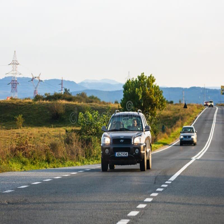

In [8]:
img.resize((224, 224))

In [9]:
x = preprocess(img)

batch_t = torch.unsqueeze(x, 0)

with torch.no_grad():
    output = model(batch_t)

_, indices = torch.sort(output, descending=True)

In [10]:
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt -O imagenet_classes.txt

--2026-01-14 19:09:34--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0.001s  

2026-01-14 19:09:35 (17.5 MB/s) - ‘imagenet_classes.txt’ saved [10472/10472]



In [11]:
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

# Get top 5 predictions
top5_indices = indices[0, :5].tolist()
top5_classes = [categories[i] for i in top5_indices]

print("Top 5 predictions:")
for i, class_name in enumerate(top5_classes):
    print(f"{i+1}: {class_name}")

Top 5 predictions:
1: minivan
2: racer
3: minibus
4: car wheel
5: tow truck


# cleanup bad images

In [15]:
import os
import pandas as pd

In [17]:
bad_files = []
df = pd.read_csv('dataset/labels_fixed.csv')
all_files = df['image_id'].tolist()
for img_filename in all_files:
    img_path = os.path.join('dataset/raw', f"{img_filename:06d}.jpg")
    try:
        with Image.open(img_path) as img:
            img.load()
    except OSError:
        bad_files.append(img_path)

print(f"Found {len(bad_files)} corrupted images")


Found 5 corrupted images


In [18]:
bad_file_id_list = []
for f in bad_files:
    print(f)
    bad_file_id = int(f.split('/')[-1].split('.')[0])
    bad_file_id_list.append(bad_file_id)

dataset/raw/000135.jpg
dataset/raw/000197.jpg
dataset/raw/000480.jpg
dataset/raw/000682.jpg
dataset/raw/000691.jpg


In [19]:
df_clean = df[~df['image_id'].isin(bad_file_id_list)]

In [20]:
df_clean[df_clean['image_id'] == 197]

,image_id,split,angle,make,model,width,height


# loading dataset

In [21]:
from torch.utils.data import Dataset

In [22]:

class CarDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None, split=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            img_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
            split (string, optional): If provided, filters the dataset to only include
                entries for the specified split (e.g., 'train', 'val', 'test').
        """
        self.img_labels = pd.read_csv(csv_file)
        # Filter out bad images
        self.img_labels = self.img_labels[~self.img_labels['image_id'].isin(bad_file_id_list)]

        # Filter out 'not_car' category
        self.img_labels = self.img_labels[self.img_labels['angle'] != 'not_car'].reset_index(drop=True)

        # Filter by split if provided
        if split:
            self.img_labels = self.img_labels[self.img_labels['split'] == split].reset_index(drop=True)

        self.img_dir = img_dir
        self.transform = transform

        # Map string labels to numerical labels
        self.label_map = {'front': 0, 'rear': 1, 'side': 2}
        self.img_labels['numeric_angle'] = self.img_labels['angle'].map(self.label_map)

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Format the image_id into a 6-digit string with .jpg extension
        img_filename = f"{self.img_labels.loc[idx, 'image_id']:06d}.jpg"
        img_name = os.path.join(self.img_dir, img_filename)

        try:
            image = Image.open(img_name).convert('RGB')
        except OSError as e:
            print(f"ERROR: Corrupted image file found: {img_name}. Error: {e}")

        label = self.img_labels.loc[idx, 'numeric_angle']

        if self.transform:
            image = self.transform(image)

        return image, label

In [23]:
# original dataset

input_size = 224

# ImageNet normalization values
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Simple transforms - just resize and normalize
train_transforms = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

val_transforms = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

test_transforms = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

Now, let's create an instance of this `CarDataset` class. I'll use the `preprocess` transformations you defined earlier and assume your `labels_fixed.csv` file is located in `/content/dataset` and image files are in `/content/dataset/raw/`. Please ensure your `labels_fixed.csv` contains columns named 'filename' for image paths and 'angle' for the categories.

## Data Augmentation
run this cell after training original dataset.   
augmentation change in place.   

In [ ]:
input_size = 224

# ImageNet normalization values
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Simple transforms - just resize and normalize
train_transforms = transforms.Compose([
    transforms.RandomRotation(5),
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),  # Zoom
    transforms.RandomHorizontalFlip(),       # Horizontal flip
    transforms.ColorJitter(
        brightness=0.15,
        contrast=0.15,
        saturation=0.1,
        hue=0.05
    ),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

val_transforms = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

test_transforms = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [24]:
csv_path = '/content/dataset/labels_fixed.csv'
image_directory = '/content/dataset/raw/'

train_dataset = CarDataset(csv_file=csv_path, img_dir=image_directory, transform=train_transforms, split='train')
val_dataset = CarDataset(csv_file=csv_path, img_dir=image_directory, transform=val_transforms, split='val')
test_dataset = CarDataset(csv_file=csv_path, img_dir=image_directory, transform=test_transforms, split='test')

In [25]:
from torch.utils.data import DataLoader

In [26]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [27]:
import torch.nn as nn

In [28]:
class CarAngleClassifierMobileNet(nn.Module):
    def __init__(self, size_inner=100, droprate=0.2, num_classes=3):
        super(CarAngleClassifierMobileNet, self).__init__()

        # Load pre-trained MobileNetV2
        self.base_model = models.mobilenet_v2(weights='IMAGENET1K_V1')

        # Freeze base model parameters
        for param in self.base_model.parameters():
            param.requires_grad = False

        # Remove original classifier
        self.base_model.classifier = nn.Identity()

        # Add custom layers
        self.global_avg_pooling = nn.AdaptiveAvgPool2d((1, 1))

        self.inner = nn.Linear(1280, size_inner)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(droprate)
        self.output_layer = nn.Linear(size_inner, num_classes)

    def forward(self, x):
        x = self.base_model.features(x)
        x = self.global_avg_pooling(x)
        x = torch.flatten(x, 1)
        x = self.inner(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.output_layer(x)
        return x

In [29]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CarAngleClassifierMobileNet(num_classes=3)
model.to(device);

In [30]:
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [31]:
# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    # Training phase
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    # Iterate over the training data
    for inputs, labels in train_loader:
        # Move data to the specified device (GPU or CPU)
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients to prevent accumulation
        optimizer.zero_grad()
        # Forward pass
        outputs = model(inputs)
        # Calculate the loss
        loss = criterion(outputs, labels)
        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Accumulate training loss
        running_loss += loss.item()
        # Get predictions
        _, predicted = torch.max(outputs.data, 1)
        # Update total and correct predictions
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate average training loss and accuracy
    train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    # Disable gradient calculation for validation
    with torch.no_grad():
        # Iterate over the validation data
        for inputs, labels in val_loader:
            # Move data to the specified device (GPU or CPU)
            inputs, labels = inputs.to(device), labels.to(device)
            # Forward pass
            outputs = model(inputs)
            # Calculate the loss
            loss = criterion(outputs, labels)

            # Accumulate validation loss
            val_loss += loss.item()
            # Get predictions
            _, predicted = torch.max(outputs.data, 1)
            # Update total and correct predictions
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    # Calculate average validation loss and accuracy
    val_loss /= len(val_loader)
    val_acc = val_correct / val_total

    # Print epoch results
    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

Epoch 1/10
  Train Loss: 1.5764, Train Acc: 0.4775
  Val Loss: 0.6783, Val Acc: 0.7394
Epoch 2/10
  Train Loss: 0.6531, Train Acc: 0.6919
  Val Loss: 0.5743, Val Acc: 0.7324
Epoch 3/10
  Train Loss: 0.4960, Train Acc: 0.7784
  Val Loss: 0.5163, Val Acc: 0.7676
Epoch 4/10
  Train Loss: 0.5393, Train Acc: 0.7748
  Val Loss: 0.6053, Val Acc: 0.7113
Epoch 5/10
  Train Loss: 0.4031, Train Acc: 0.8270
  Val Loss: 0.4774, Val Acc: 0.7958
Epoch 6/10
  Train Loss: 0.5392, Train Acc: 0.7784
  Val Loss: 0.3919, Val Acc: 0.8451
Epoch 7/10
  Train Loss: 0.3864, Train Acc: 0.8649
  Val Loss: 0.5260, Val Acc: 0.7676
Epoch 8/10
  Train Loss: 0.3987, Train Acc: 0.8414
  Val Loss: 0.3549, Val Acc: 0.8521
Epoch 9/10
  Train Loss: 0.2709, Train Acc: 0.9045
  Val Loss: 0.4211, Val Acc: 0.8239
Epoch 10/10
  Train Loss: 0.2355, Train Acc: 0.9063
  Val Loss: 0.4211, Val Acc: 0.8028


In [32]:
import matplotlib.pyplot as plt

In [33]:
# original

train_acc0 = [0.4775, 0.6919, 0.7784, 0.7748, 0.8270, 0.7784, 0.8649, 0.8414, 0.9045, 0.9063]
val_acc0 = [0.7394, 0.7324, 0.7676, 0.7113, 0.7958, 0.8451, 0.7676, 0.8521, 0.8239, 0.8028]

# bumpy curve

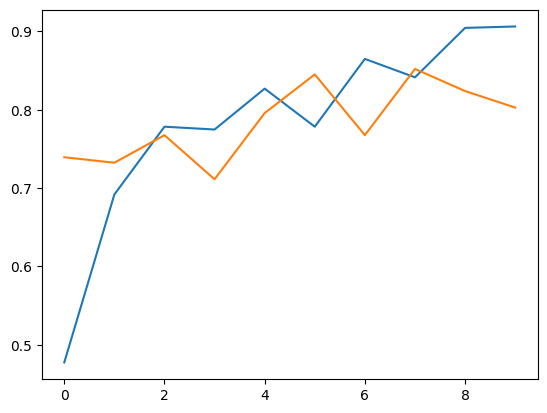

In [34]:
plt.plot(train_acc0, label='train')
plt.plot(val_acc0, label='val')

plt.show()

In [ ]:
# transforms.RandomRotation(10),           # Rotate up to 10 degrees
# transforms.RandomResizedCrop(224, scale=(0.85, 1.0)),  # Zoom

train_acc1 = [0.8144, 0.8937, 0.9153, 0.9081, 0.9369, 0.9279, 0.9189, 0.9315, 0.9387, 0.9351]
val_acc1 = [0.8099, 0.7958, 0.8028, 0.7465, 0.8028, 0.7746, 0.8239, 0.7606, 0.7535, 0.8169]

# looks like over learning some features not existing in val. maybe rotate and zoom in too much?

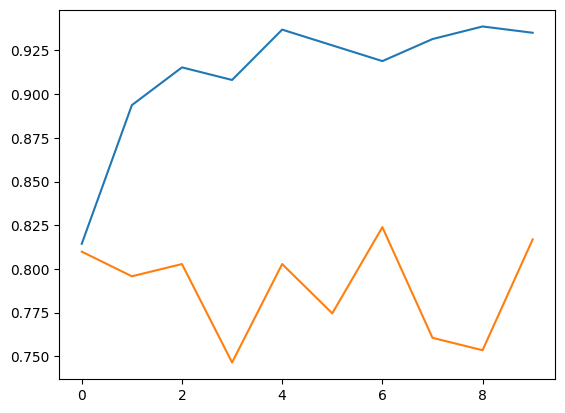

In [ ]:


plt.plot(train_acc1, label='train')
plt.plot(val_acc1, label='val')

plt.show()

In [ ]:
# transforms.RandomRotation(5),
# transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),  # Zoom
# transforms.ColorJitter(
#         brightness=0.15,
#         contrast=0.15,
#         saturation=0.1,
#         hue=0.05
#     ),

train_acc2 = [0.9568, 0.8919, 0.8721, 0.8468, 0.9027, 0.9135, 0.9514, 0.9243, 0.9099, 0.9676]
val_acc2 = [0.7887, 0.7465, 0.7746, 0.7394, 0.7746, 0.7958, 0.7958, 0.8380, 0.8310, 0.7958]



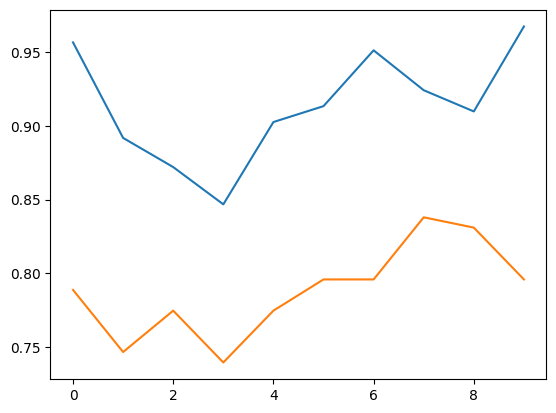

In [ ]:
plt.plot(train_acc2, label='train')
plt.plot(val_acc2, label='val')

plt.show()

In [ ]:
def train_and_evaluate(model, optimizer, train_loader, val_loader, criterion, num_epochs, device):
    best_val_accuracy = 0.0  # Initialize variable to track the best validation accuracy


    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = val_correct / val_total

        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

        if val_acc > best_val_accuracy:
            best_val_accuracy = val_acc
            checkpoint_path = f'car_angle_v4_{epoch+1:02d}_{val_acc:.3f}.pth'
            torch.save(model.state_dict(), checkpoint_path)
            print(f'Checkpoint saved: {checkpoint_path}')

In [ ]:
def make_model(learning_rate=0.001, size_inner=100, droprate=0.2):
  model = CarAngleClassifierMobileNet(
      num_classes=3,
      size_inner=size_inner,
      droprate=droprate
  )
  model.to(device)
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)
  criterion = nn.CrossEntropyLoss()
  return model, optimizer, criterion

In [ ]:
num_epochs = 50

model, optimizer, criterion = make_model(
    learning_rate=0.001,
    size_inner=100,
    droprate=0.2
)



In [ ]:
train_and_evaluate(model, optimizer, train_loader, val_loader, criterion, num_epochs, device)

Epoch 1/50
  Train Loss: 0.8760, Train Acc: 0.6108
  Val Loss: 0.6172, Val Acc: 0.7887
Checkpoint saved: car_angle_v4_01_0.789.pth
Epoch 2/50
  Train Loss: 0.5199, Train Acc: 0.8018
  Val Loss: 0.4864, Val Acc: 0.8169
Checkpoint saved: car_angle_v4_02_0.817.pth
Epoch 3/50
  Train Loss: 0.4053, Train Acc: 0.8577
  Val Loss: 0.4610, Val Acc: 0.8099
Epoch 4/50
  Train Loss: 0.3303, Train Acc: 0.8793
  Val Loss: 0.4912, Val Acc: 0.7887
Epoch 5/50
  Train Loss: 0.2998, Train Acc: 0.8847
  Val Loss: 0.5267, Val Acc: 0.7958
Epoch 6/50
  Train Loss: 0.3327, Train Acc: 0.8811
  Val Loss: 0.5039, Val Acc: 0.8239
Checkpoint saved: car_angle_v4_06_0.824.pth
Epoch 7/50
  Train Loss: 0.2586, Train Acc: 0.9117
  Val Loss: 0.4187, Val Acc: 0.8521
Checkpoint saved: car_angle_v4_07_0.852.pth
Epoch 8/50
  Train Loss: 0.2184, Train Acc: 0.9225
  Val Loss: 0.4498, Val Acc: 0.8451
Epoch 9/50
  Train Loss: 0.2653, Train Acc: 0.9081
  Val Loss: 0.5213, Val Acc: 0.8099
Epoch 10/50
  Train Loss: 0.2326, Train A

In [ ]:
train_acc3 = [0.6108, 0.8018, 0.8577, 0.8793, 0.8847, 0.8811, 0.9117, 0.9225, 0.9081, 0.9045,
              0.9009, 0.9081, 0.9117, 0.9027, 0.9027, 0.9297, 0.9243, 0.9459, 0.9225, 0.9369,
              0.9333, 0.9405, 0.9423, 0.9333, 0.9658, 0.9712, 0.9441, 0.9351, 0.9586, 0.9604,
              0.9514, 0.9550, 0.9369, 0.9477, 0.9604, 0.9477, 0.9333, 0.9441, 0.9459, 0.9550,
              0.9387, 0.9694, 0.9586, 0.9640, 0.9712, 0.9784, 0.9820, 0.9694, 0.9315, 0.9495]
val_acc3 = [0.7887, 0.8169, 0.8099, 0.7887, 0.7958, 0.8239, 0.8521, 0.8451, 0.8099, 0.7817,
            0.8239, 0.8028, 0.8310, 0.8169, 0.8028, 0.7958, 0.8239, 0.8521, 0.8239, 0.8169,
            0.8028, 0.8239, 0.8310, 0.8310, 0.8451, 0.8451, 0.8310, 0.8380, 0.8380, 0.8239,
            0.8310, 0.8521, 0.8380, 0.8380, 0.8380, 0.8521, 0.8380, 0.8451, 0.8451, 0.8099,
            0.8451, 0.8310, 0.8592, 0.8592, 0.8310, 0.8239, 0.8310, 0.8310, 0.8169, 0.8239]


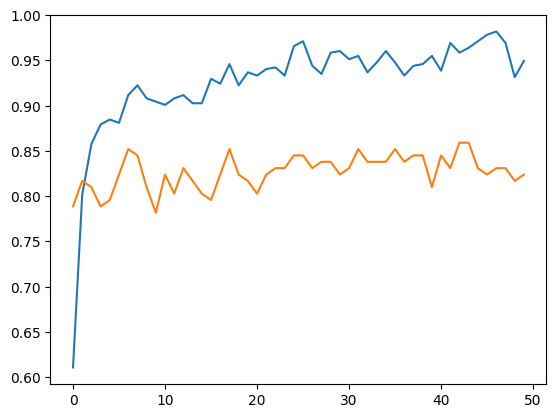

In [ ]:

plt.plot(train_acc3, label='train')
plt.plot(val_acc3, label='val')

plt.show()

model_path = 'car_angle_v4_43_0.859.pth'

Instantiate the model with the same architecture as the saved model
Assuming CarAngleClassifierMobileNet and its dependencies are already defined in the notebook
model_onnx = CarAngleClassifierMobileNet(num_classes=3)
model_onnx.to(device)

Load the saved state dictionary
model_onnx.load_state_dict(torch.load(model_path, map_location=device))

Set the model to evaluation mode
model_onnx.eval()

Next, we'll create a dummy input tensor. This is necessary because torch.onnx.export needs to trace the model's computation graph with a sample input. The dimensions of this dummy input should match the expected input dimensions of your model (e.g., batch_size, channels, height, width).

Finally, we use torch.onnx.export to convert the model. You'll specify the model, the dummy input, the output ONNX file name, and other parameters like input/output names and dynamic axes if needed. Dynamic axes are useful if you want your ONNX model to be flexible with batch size or other dimensions.

In [ ]:
model_path = 'car_angle_v4_43_0.859.pth'

# Instantiate the model with the same architecture as the saved model

model_onnx = CarAngleClassifierMobileNet(
    num_classes=3,
    size_inner=100,
    droprate=0.2
)
model_onnx.to(device)

# Load the saved state dictionary
model_onnx.load_state_dict(torch.load(model_path, map_location=device))

# Set the model to evaluation mode
model_onnx.eval()

CarAngleClassifierMobileNet(
  (base_model): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16,

In [ ]:
# Create a dummy input tensor matching the expected input size (e.g., 1 batch, 3 channels, 224x224 pixels)
dummy_input = torch.randn(1, 3, 224, 224).to(device)

In [ ]:
onnx_model_path = 'car_angle_classifier.onnx'

try:
    torch.onnx.export(
        model_onnx,                            # model being run
        dummy_input,                         # model input (or a tuple for multiple inputs)
        onnx_model_path,                     # where to save the model (can be a file or file-like object)
        export_params=True,                  # store the trained parameter weights inside the model file
        opset_version=17,                    # the ONNX version to export the model to
        do_constant_folding=True,            # whether to execute constant folding for optimization
        input_names = ['input'],             # the name to assign to the input node
        output_names = ['output'],           # the name to assign to the output node
        dynamic_axes={
            'input' : {0 : 'batch_size'},
            'output' : {0 : 'batch_size'}
        }
    )
    print(f"Model successfully converted to ONNX and saved at {onnx_model_path}")
except Exception as e:
    print(f"Error during ONNX export: {e}")

/tmp/ipython-input-732493844.py:4: UserWarning: # 'dynamic_axes' is not recommended when dynamo=True, and may lead to 'torch._dynamo.exc.UserError: Constraints violated.' Supply the 'dynamic_shapes' argument instead if export is unsuccessful.
  torch.onnx.export(
W0108 16:10:51.617000 1809 torch/onnx/_internal/exporter/_compat.py:114] Setting ONNX exporter to use operator set version 18 because the requested opset_version 17 is a lower version than we have implementations for. Automatic version conversion will be performed, which may not be successful at converting to the requested version. If version conversion is unsuccessful, the opset version of the exported model will be kept at 18. Please consider setting opset_version >=18 to leverage latest ONNX features


[torch.onnx] Obtain model graph for `CarAngleClassifierMobileNet([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `CarAngleClassifierMobileNet([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅


Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/__init__.py", line 127, in call
    converted_proto = _c_api_utils.call_onnx_api(
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/_c_api_utils.py", line 65, in call_onnx_api
    result = func(proto)
             ^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/__init__.py", line 122, in _partial_convert_version
    return onnx.version_converter.convert_version(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnx/version_converter.py", line 39, in convert_version
    converted_model_str = C.convert_version(model_str, target_version)
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: /github/workspace/onnx/version_converter/adapters/axes_input_to_attribute.h:65: adapt: Asserti

Applied 105 of general pattern rewrite rules.
Model successfully converted to ONNX and saved at car_angle_classifier.onnx


In [ ]:
!pip install onnxscript onnx onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.4/693.4 kB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 98.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 79.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.1/139.1 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 7.2 MB/s eta 0:00:00


In [ ]:
onnx_model_path = 'car_angle_classifier.onnx'

try:
    torch.onnx.export(
        model_onnx,                            # model being run
        dummy_input,                         # model input (or a tuple for multiple inputs)
        onnx_model_path,                     # where to save the model (can be a file or file-like object)
        export_params=True,                  # store the trained parameter weights inside the model file
        opset_version=11,                    # the ONNX version to export the model to
        do_constant_folding=True,            # whether to execute constant folding for optimization
        input_names = ['input'],             # the name to assign to the input node
        output_names = ['output'],           # the name to assign to the output node
        dynamic_axes={
            'input' : {0 : 'batch_size'},
            'output' : {0 : 'batch_size'}
        }
    )
    print(f"Model successfully converted to ONNX and saved at {onnx_model_path}")
except Exception as e:
    print(f"Error during ONNX export: {e}")